<a href="https://colab.research.google.com/github/sureshmecad/Deep-Learning/blob/main/1_Seeding_Classification_CNN_Let_The_Data_Confess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
import cv2

ScaleTo = 70  # px to scale
seed = 7  # fixing random

#/content/drive/MyDrive/train_plant_classification/Black-grass/0050f38b3.png
path = '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/*/*.png' 
files = glob(path)
print(files)

trainImg = []
trainLabel = []
j = 1
num = len(files)
print(num)
print(str(j) + "/" + str(num))

# Obtain images and resizing, obtain labels
for img in files:
  #print("file name is going to print")
  print(str(j) + "/" + str(num))
  trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
  trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
  j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

['/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/0be707615.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/0b3e7a7a9.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/0b228a6b8.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/fc1001932.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/fef14b865.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/f423f84da.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/f82d13d23.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plant_classification/Black-grass/f47390401.png', '/content/drive/MyDrive/seedling classification for bootcamp/train_plan

In [13]:
print(trainImg.shape)
print(trainLabel.shape)

(1169, 70, 70, 3)
(1169, 1)


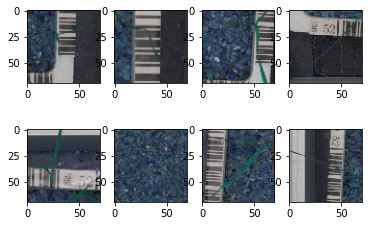

In [14]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

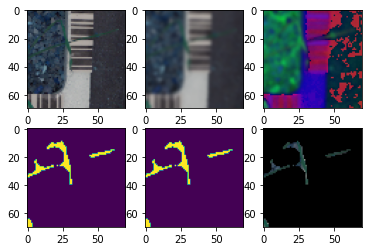

In [15]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

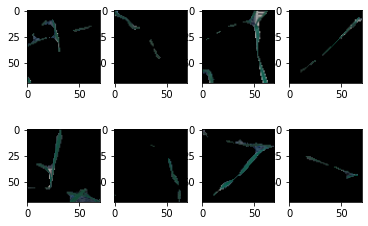

In [16]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

### Normalization

In [17]:
clearTrainImg = clearTrainImg / 255

### Label Encoding

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


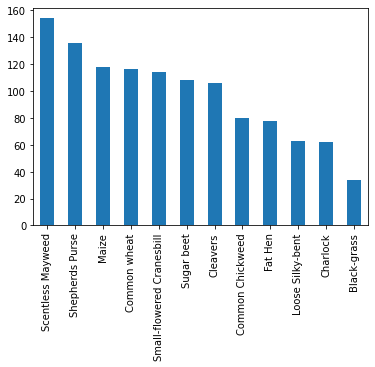

In [18]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

### Train, Validation and Test split

In [19]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.3, random_state=seed, 
                                                stratify = clearTrainLabel)

In [20]:
X_test, X_val, y_test, y_val = train_test_split(testX, testY, test_size=0.5, random_state=1) 

### Print label for train_y

In [21]:
trainY[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

### Building CNN model, defining layers, loss function and optimizier

In [22]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

# model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       4

### Image Augmentation

In [23]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

### Train the model and saving best model as check point

In [24]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="/content/drive/MyDrive/seedling classification for bootcamp/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="/content/drive/MyDrive/seedling classification for bootcamp/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

In [25]:
hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=32), 
                           epochs= 5, validation_data=(X_val, y_val), 
                           steps_per_epoch= 10, callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 76s 8s/step - loss: 3.4974 - accuracy: 0.1937 - val_loss: 2.5843 - val_accuracy: 0.1534

Epoch 00001: val_accuracy improved from -inf to 0.15341, saving model to /content/drive/MyDrive/seedling classification for bootcamp/weights.best_01-0.15.hdf5

Epoch 00001: saving model to /content/drive/MyDrive/seedling classification for bootcamp/weights.last_auto4.hdf5
Epoch 2/5
10/10 [==============================] - 74s 7s/step - loss: 2.6187 - accuracy: 0.2647 - val_loss: 4.4104 - val_accuracy: 0.1080

Epoch 00002: val_accuracy did not improve from 0.15341

Epoch 00002: saving model to /content/drive/MyDrive/seedling classification for bootcamp/weights.last_auto4.hdf5
Epoch 3/5
10/10 [==============================] - 72s 7s/step - loss: 2.3060 - accuracy: 0.3170 - val_loss: 7.4158 - val_accuracy: 0.0682

Epoch 00003: val_accuracy did not improve from 0.15341

Epoch 00003: saving model to /content/drive/MyDrive/seedling classification for bo

### Model Evaluation

In [28]:
model.load_weights("/content/drive/MyDrive/seedling classification for bootcamp/weights.best_04-0.10.hdf5")

final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

print(model.evaluate(trainX, trainY))  # Evaluate on train set

6/6 [==============================] - 9s 2s/step - loss: 30.3672 - accuracy: 0.0286
Final Loss: 30.36719512939453, Final Accuracy: 0.02857142873108387
26/26 [==============================] - 45s 2s/step - loss: 30.2433 - accuracy: 0.0293
[30.24329376220703, 0.029339853674173355]


### Plotting confusion matrix

In [29]:
print(model.evaluate(X_val, y_val))

6/6 [==============================] - 9s 2s/step - loss: 30.3941 - accuracy: 0.0284
[30.394147872924805, 0.028409091755747795]


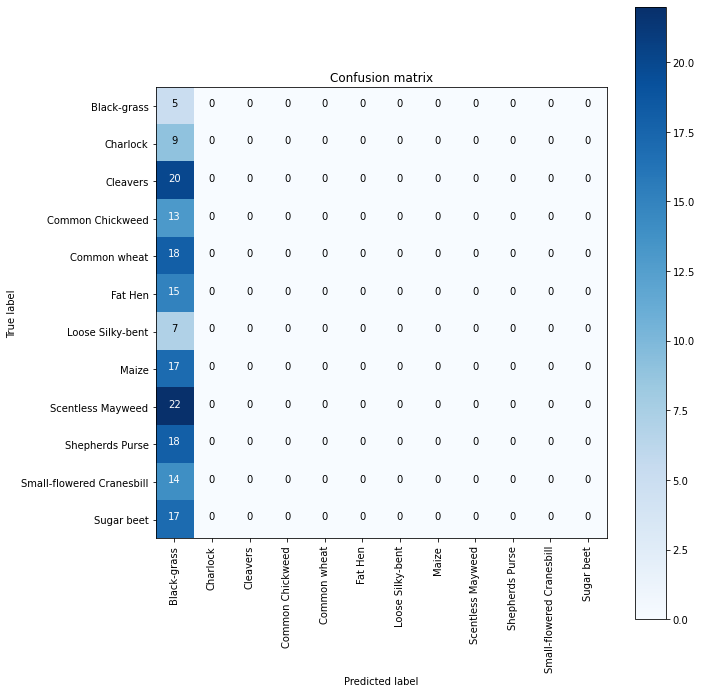

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(X_test)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_)

### Prediction on x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [31]:
cleanTestImg = [X_test[2],X_test[3],X_test[33],X_test[36],X_test[59]]
for i in cleanTestImg:
  #print(i.shape)
  i = np.expand_dims(i, axis=0)
  pred = model.predict(i)
  #print(pred)
  predNum = np.argmax(pred, axis=1)
  predStr = le.classes_[predNum]
  print(predStr)

['Black-grass']
['Black-grass']
['Black-grass']
['Black-grass']
['Black-grass']


In [32]:
cleanTestLabel = [y_test[2],y_test[3],y_test[33],y_test[36],y_test[59]]
for i in cleanTestLabel:
  TrueNum = np.argmax(i)
  TrueStr = le.classes_[TrueNum]
  print(TrueStr)

Maize
Common Chickweed
Cleavers
Small-flowered Cranesbill
Maize
